In [1]:
import numpy as np
from math import acos, pi
import matplotlib.pyplot as plt
import os
import pandas as pd

import sys
sys.path.append("../../")

#project_folder = "C:\\Users\\giogu\\Documents\\Acustica\\python_routines" 
#sys.path.append(project_folder)

#from pyEnvAcoustics.instruments.LD_831.read_data import read_LD_831_data
#from pyEnvAcoustics.instruments.commons import add_masks_to_df, get_masks

from pyAcousticsAnalysis.instruments.LD_831.read_data import read_LD_831_data
from pyAcousticsAnalysis.instruments.commons import add_masks_to_df, get_masks

#from analisi_misure.helper_functions import save_LD831_data, save_masks, get_masks, read_LD831_data_new, read_LD831_data_v2
from matplotlib.widgets import SpanSelector

#from analisi_misure.helper_functions import get_mean_levels, get_max_levels, get_min_levels, save_data, read_data

%matplotlib widget

%load_ext autoreload
%autoreload 2

### GUI functions

In [2]:
def onselect_main_plot(xmin, xmax):
    indmin, indmax = np.searchsorted(x, (xmin, xmax))
    indmax = min(len(x) - 1, indmax)
    thisx = x[indmin:indmax]
#    thisy = y[indmin:indmax]

    ax_1.set_xlim(thisx[0], thisx[-1])
    fig.canvas.draw()
    
#    cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [3]:
def onselect_zoom_plot(xmin, xmax):
    indmin, indmax = np.searchsorted(x, (xmin, xmax))
    indmax = min(len(x) - 1, indmax)

    thisx = x[indmin:indmax]
#    thisy = y[indmin:indmax]
    list_masks.append((thisx[0], thisx[-1]))
#    save_masks(list_masks, df)

    ax_0.plot(x, y, color="blue")    
    ax_0.plot(df[df['masked']==False]['timestamp'].values, df[df['masked']==False][channel].expanding().mean(), 
              color="black",  linewidth=3)

    for mask in list_masks:
        ax_1.plot([mask[0], mask[1]], [L_max, L_max], linewidth=2, color='red')    
        ax_1.plot([mask[0], mask[1]], [L_min, L_min], linewidth=2, color='red')    
        ax_1.plot([mask[0], mask[0]], [L_min, L_max], linewidth=2, color='red')    
        ax_1.plot([mask[1], mask[1]], [L_min, L_max], linewidth=2, color='red')    

    for mask in list_masks:
        ax_0.plot([mask[0], mask[1]], [L_max, L_max], linewidth=2, color='red')    
        ax_0.plot([mask[0], mask[1]], [L_min, L_min], linewidth=2, color='red')    
        ax_0.plot([mask[0], mask[0]], [L_min, L_max], linewidth=2, color='red')    
        ax_0.plot([mask[1], mask[1]], [L_min, L_max], linewidth=2, color='red')    

    fig.canvas.draw()

In [4]:
def onclick(event):
    if event.button == 3:
        x_click = event.xdata
        ind_to_remove = None

        for ind_mask, mask in enumerate(list_masks):
            if x_click > mask[0] and x_click < mask[1]:
                ind_to_remove = ind_mask     
        del(list_masks[ind_to_remove])
        
#    save_masks(list_masks, df)

    #redraw axis 0
    ax_0.cla()  
    ax_0.plot(x, y, color="blue")
    ax_0.plot(df[df['masked']==False]['timestamp'].values, df[df['masked']==False][channel].expanding().mean(), 
              color="black",  linewidth=3)

    ax_0.set_title("Time history")
    for mask in list_masks:
        ax_0.plot([mask[0], mask[1]], [L_max, L_max], linewidth=2, color='red')    
        ax_0.plot([mask[0], mask[1]], [L_min, L_min], linewidth=2, color='red')    
        ax_0.plot([mask[0], mask[0]], [L_min, L_max], linewidth=2, color='red')    
        ax_0.plot([mask[1], mask[1]], [L_min, L_max], linewidth=2, color='red')    

    #redraw axis 1
    ax_1_lim = ax_1.get_xlim()
    ax_1.cla()      
    ax_1.set_xlim(ax_1_lim)
    ax_1.plot(x, y, color="blue")
    ax_1.plot(df[df['masked']==False]['timestamp'].values, df[df['masked']==False][channel].expanding().mean(), 
              color="black",  linewidth=3)

    ax_1.set_title("zoom")
    for mask in list_masks:
        ax_1.plot([mask[0], mask[1]], [L_max, L_max], linewidth=2, color='red')    
        ax_1.plot([mask[0], mask[1]], [L_min, L_min], linewidth=2, color='red')    
        ax_1.plot([mask[0], mask[0]], [L_min, L_max], linewidth=2, color='red')    
        ax_1.plot([mask[1], mask[1]], [L_min, L_max], linewidth=2, color='red')    

### Folders

In [5]:
base_folder = "../../formificio_Padova"

In [6]:
misure_folder = os.path.join(base_folder, "./misure")

reports_folder = os.path.join(base_folder, "./reports")
data_folder = os.path.join(reports_folder, "data")
os.makedirs(data_folder, exist_ok=True) 
preprocessed_folder = os.path.join(reports_folder, "preprocessed")
os.makedirs(preprocessed_folder, exist_ok=True) 

In [7]:
filenames = sorted([x for x in os.listdir(misure_folder) if x.endswith(".xlsx")])
#print(filenames)
#print()
print("num files:", len(filenames))

num files: 7


831_0003315-20240314 171901-447TH_M.010.xlsx
831_0003315-20240314 173756-447TH_M.012.xlsx
831_0003315-20240314 175343-447TH_M.013.xlsx
831_0003315-20240314 181055-447TH_M.014.xlsx
831_0003315-20240314 182706-447TH_M.015.xlsx


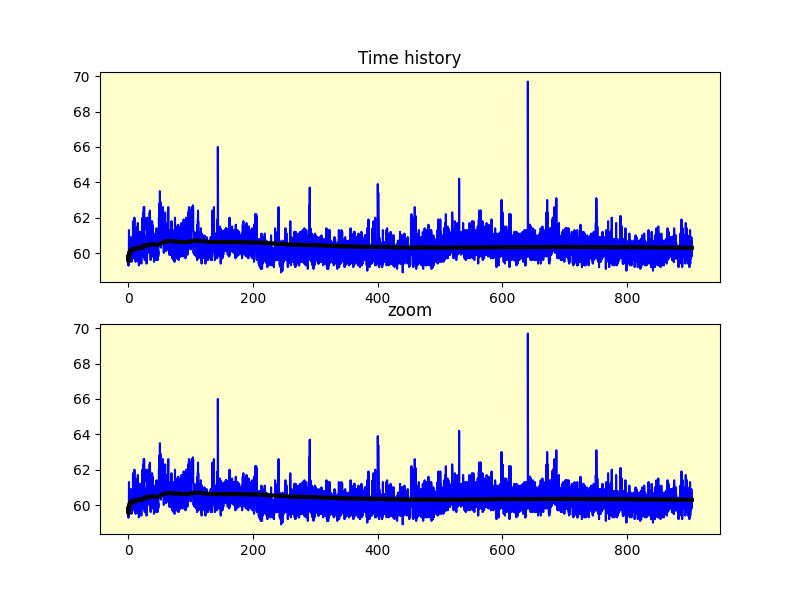

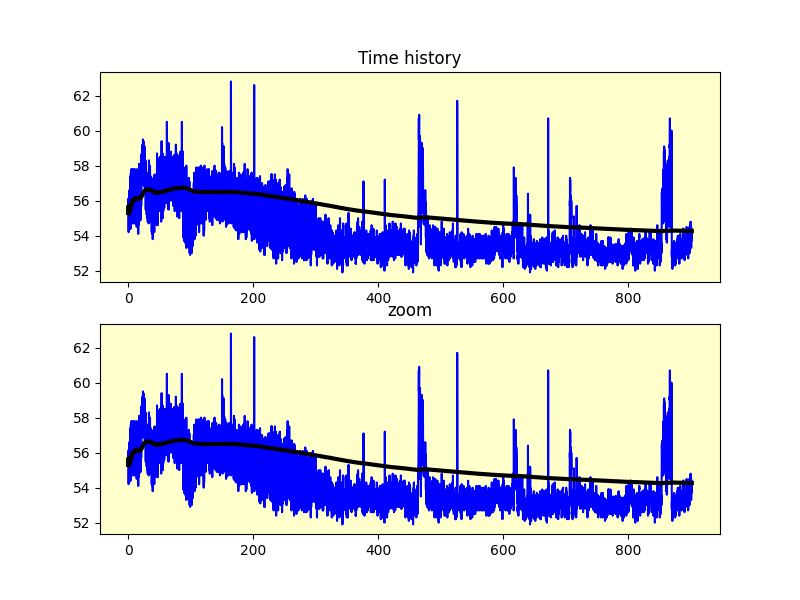

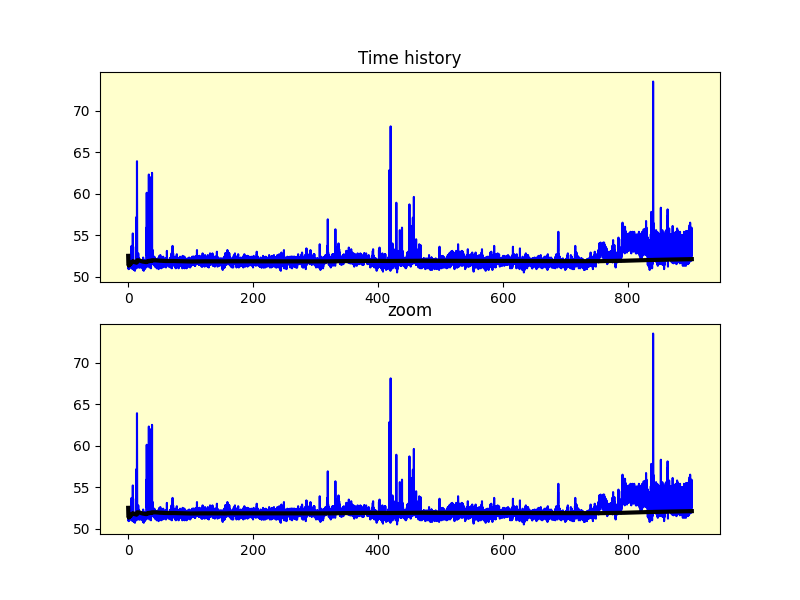

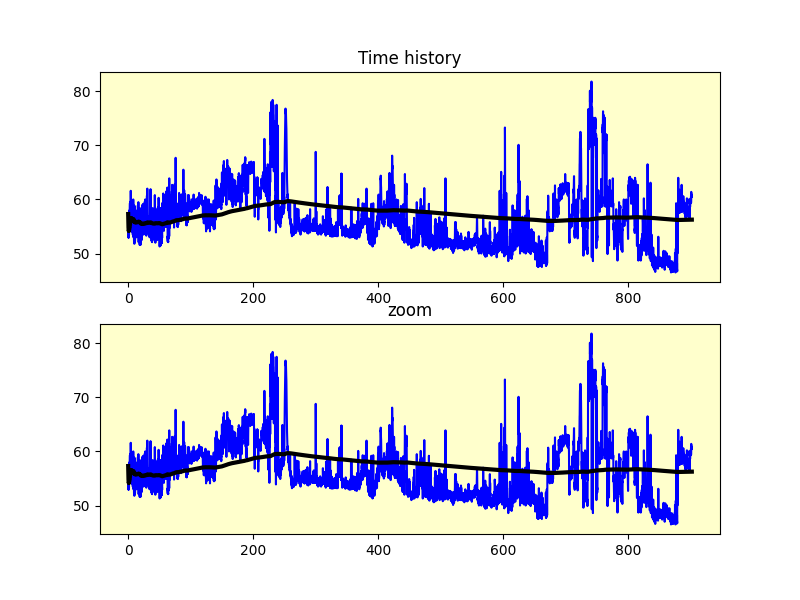

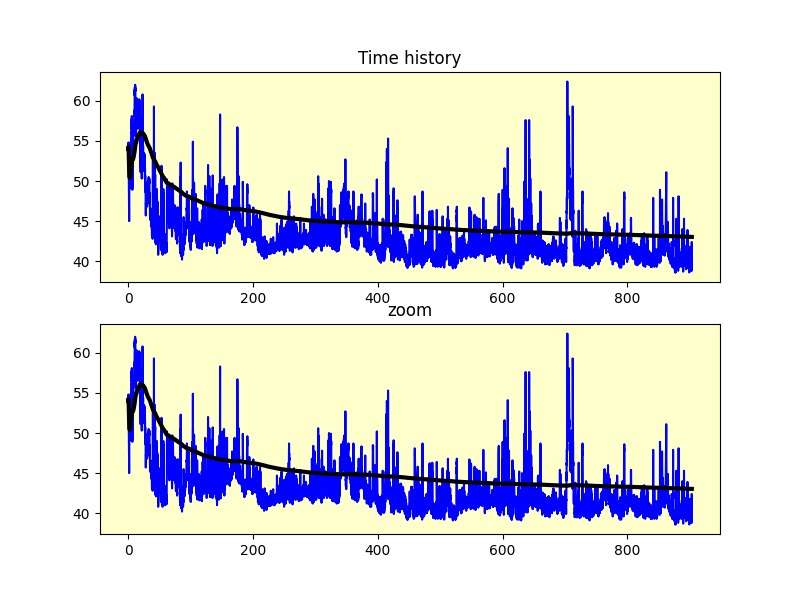

In [12]:
for filename in filenames[2:]:
    print(filename)
    nome_misura = filename.split("-")[-1].replace(".xlsx", ".s")
    file_path = os.path.join(misure_folder, filename)
    
    df = read_LD_831_data(file_path)
    
    list_masks = []

    channel = "LAeq"

    x = np.round(df['timestamp'].values, 2)
    y = df[channel].values
    y_running = df[channel].expanding().mean()
    L_max = df[channel].max()
    L_min = df[channel].min()

    fig = plt.figure(figsize=(8, 6))
    ax_0 = fig.add_subplot(2, 1, 1, facecolor='#FFFFCC')
    ax_1 = fig.add_subplot(2, 1, 2, facecolor='#FFFFCC')
    #ax_2 = fig.add_subplot(3, 1, 3, facecolor='#FFFFCC')

    ax_0.plot(x, y, color="blue")
    ax_0.plot(df[df['masked']==False]['timestamp'].values, df[df['masked']==False][channel].expanding().mean(), color="black",  linewidth=3)

    ax_0.set_title("Time history")
    ax_1.plot(x, y, color="blue")
    ax_1.plot(df[df['masked']==False]['timestamp'].values, df[df['masked']==False][channel].expanding().mean(), color="black",  linewidth=3)
    ax_1.set_title("zoom")

    for mask in list_masks:
        ax_1.plot([mask[0], mask[1]], [L_max, L_max], linewidth=2, color='red')    
        ax_1.plot([mask[0], mask[1]], [L_min, L_min], linewidth=2, color='red')    
        ax_1.plot([mask[0], mask[0]], [L_min, L_max], linewidth=2, color='red')    
        ax_1.plot([mask[1], mask[1]], [L_min, L_max], linewidth=2, color='red')    

    for mask in list_masks:
        ax_0.plot([mask[0], mask[1]], [L_max, L_max], linewidth=2, color='red')    
        ax_0.plot([mask[0], mask[1]], [L_min, L_min], linewidth=2, color='red')    
        ax_0.plot([mask[0], mask[0]], [L_min, L_max], linewidth=2, color='red')    
        ax_0.plot([mask[1], mask[1]], [L_min, L_max], linewidth=2, color='red')    


    #fig.canvas.mpl_connect('button_press_event', onclick)

    # set useblit True on gtkagg for enhanced performance
    span_1 = SpanSelector(ax_0, onselect_main_plot, 'horizontal', useblit=True, button=1, ignore_event_outside=False, 
                          props=dict(alpha=0.5, facecolor='red'), interactive = True)
    span_2 = SpanSelector(ax_1, onselect_zoom_plot, 'horizontal', useblit=True, button=1, ignore_event_outside=False, 
                          props=dict(alpha=0.5, facecolor='red'))
    #cid = fig.canvas.mpl_connect('button_press_event', onclick)
    #cid = fig.canvas.mpl_connect('button_press_event', mouseDoubleClick)

    cid = fig.canvas.mpl_connect('button_press_event', onclick)

#    plt.show()
    
    add_masks_to_df(list_masks, df)
    df.to_excel(os.path.join(preprocessed_folder, filename), sheet_name="Profilo storico")  

In [11]:
add_masks_to_df(list_masks, df)
df.to_excel(os.path.join(preprocessed_folder, filename), sheet_name="Profilo storico")  

In [ ]:
file_path = os.path.join(base_folder, filename)
df = read_LD_831_data(file_path)

In [ ]:
#df

In [ ]:
#read processed data

#data_dict, list_masks = read_data("test_data.xlsx")

In [ ]:
#list_masks

### Maschera misura (controllare se funziona aggiornamento running Leq)

### Save data with masks

In [ ]:
list_masks

In [ ]:
save_masks(list_masks, df)

In [ ]:
#df[df['masked'] == True]

### Dump excel

In [ ]:
save_data(data_dict, "test_data.xlsx")

In [ ]:
#get_masks(df)

In [ ]:
#df[df['mascherato']].shape